# Experiment 4. Обучение модели с использованием PyTorch

## Цель эксперимента

Цель данного эксперимента заключается в оценке влияния обработки пропусков на производительность модели машинного обучения. Мы будем использовать `SimpleImputer` для заполнения пропусков в данных, а затем обучим простую нейронную сеть с использованием библиотеки PyTorch.

## Описание данных

Данные загружаются из файла `processed_application_train.csv`, который содержит информацию о заявках. Целевая переменная обозначена как `target`, и мы будем использовать остальные столбцы в качестве признаков для обучения модели.

## Процесс эксперимента

1. **Загрузка данных**: Данные загружаются из CSV файла с использованием библиотеки pandas.

2. **Обработка пропусков**: 
   - Для заполнения пропусков в данных используется `SimpleImputer` с стратегией `most_frequent`, что позволяет заменить пропуски наиболее частым значением в каждом столбце.
   
3. **Разделение данных**: Данные разделяются на обучающую и тестовую выборки с использованием `train_test_split` из библиотеки scikit-learn.

4. **Стандартизация данных**: Признаки стандартизируются с помощью `StandardScaler`, чтобы привести их к одному масштабу.

5. **Создание тензоров**: Данные преобразуются в тензоры PyTorch для дальнейшего использования в модели.

6. **Определение модели**: Создается простая нейронная сеть с двумя скрытыми слоями и выходным слоем с активацией сигмоид для бинарной классификации.

7. **Обучение модели**: Модель обучается на обучающей выборке с использованием бинарной кросс-энтропии в качестве функции потерь и Adam в качестве оптимизатора.

8. **Оценка модели**: После обучения модель оценивается на тестовой выборке, и вычисляется точность предсказаний.

## Результаты

В результате эксперимента мы получим значение точности модели на тестовой выборке, что позволит оценить, насколько эффективно заполнение пропусков повлияло на производительность модели.

## Заключение

Данный эксперимент поможет понять, как обработка пропусков в данных влияет на качество предсказаний модели. Результаты могут быть использованы для дальнейших улучшений в предобработке данных и выборе моделей.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset

from roc_auc import plot_roc_curve

C:\Users\carka\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
target_column = 'TARGET'

In [4]:
data = pd.read_csv("processed_application_train.csv", index_col=0)

In [5]:
# Предположим, что 'target' - это целевая переменная
X = data.drop(columns=[target_column]).values
y = data[target_column].values

# Обработка пропусков с помощью SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 400)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        self.prelu1 = nn.PReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(400, 160)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        self.prelu2 = nn.PReLU()
        self.bn2 = nn.BatchNorm1d(160)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(160, 64)
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        self.prelu3 = nn.PReLU()
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, 26)
        nn.init.kaiming_normal_(self.fc4.weight, nonlinearity='relu')
        self.prelu4 = nn.PReLU()
        self.bn4 = nn.BatchNorm1d(26)
        self.dropout4 = nn.Dropout(0.3)

        self.fc5 = nn.Linear(26, 12)
        nn.init.kaiming_normal_(self.fc5.weight, nonlinearity='relu')
        self.prelu5 = nn.PReLU()
        self.bn5 = nn.BatchNorm1d(12)
        self.dropout5 = nn.Dropout(0.3)

        self.fc6 = nn.Linear(12, 1)

    def forward(self, x):
        x = self.dropout1(self.prelu1(self.fc1(x)))
        x = self.dropout2(self.bn2(self.prelu2(self.fc2(x))))
        x = self.dropout3(self.bn3(self.prelu3(self.fc3(x))))
        x = self.dropout4(self.bn4(self.prelu4(self.fc4(x))))
        x = self.dropout5(self.bn5(self.prelu5(self.fc5(x))))
        x = torch.sigmoid(self.fc6(x))
        return x


Divice is cpu
Epoch [1/30], Loss: 0.3097
Epoch [2/30], Loss: 0.2542
Epoch [3/30], Loss: 0.0892
Epoch [4/30], Loss: 0.5036
Epoch [5/30], Loss: 0.5762
Epoch [6/30], Loss: 0.1944
Epoch [7/30], Loss: 0.2159
Epoch [8/30], Loss: 0.2716
Epoch [9/30], Loss: 0.4943
Epoch [10/30], Loss: 0.2809
Epoch [11/30], Loss: 0.0911
Epoch [12/30], Loss: 0.0896
Epoch [13/30], Loss: 0.1512
Epoch [14/30], Loss: 0.1282
Epoch [15/30], Loss: 0.5272
Epoch [16/30], Loss: 0.0891
Epoch [17/30], Loss: 0.0872
Epoch [18/30], Loss: 0.3879
Epoch [19/30], Loss: 0.1916
Epoch [20/30], Loss: 0.4250
Epoch [21/30], Loss: 0.4292
Epoch [22/30], Loss: 0.2135
Epoch [23/30], Loss: 0.2963
Epoch [24/30], Loss: 0.1544
Epoch [25/30], Loss: 0.0919
Epoch [26/30], Loss: 0.2360
Epoch [27/30], Loss: 0.1137
Epoch [28/30], Loss: 0.2108
Epoch [29/30], Loss: 0.1613
Epoch [30/30], Loss: 0.1660


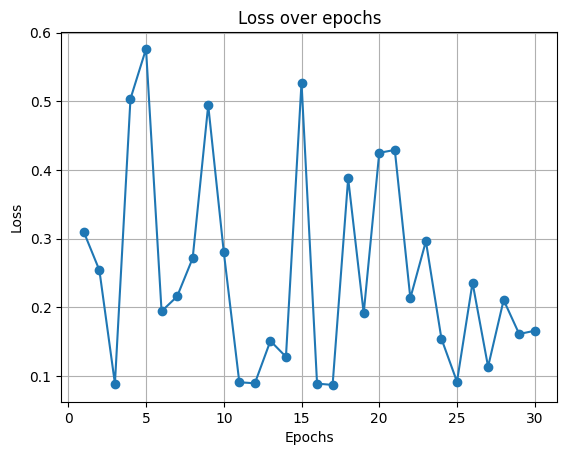

In [7]:
# Создание DataLoader
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1) 
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Инициализация модели, функции потерь и оптимизатора
model = SimpleNN()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Divice is {device}")
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# Обучение модели
num_epochs = 30
losses = [] 

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs)  
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = (y_pred > 0.5).float()


# Вывод значений потерь
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [9]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.9194


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Precision: 0.3763, Recall: 0.0047, F1 Score: 0.0093


In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[84783    58]
 [ 7378    35]]


In [13]:
y_pred = model(X_test_tensor)  # Получаем вероятности, а не бинарные метки
auc = roc_auc_score(y_test, y_pred.detach().cpu().numpy())
print(f'ROC AUC: {auc:.4f}')


ROC AUC: 0.7169


Divice is cpu
Epoch [1/30], Loss: 0.3770
Epoch [2/30], Loss: 0.1454
Epoch [3/30], Loss: 0.1576
Epoch [4/30], Loss: 0.3549
Epoch [5/30], Loss: 0.2490
Epoch [6/30], Loss: 0.1977
Epoch [7/30], Loss: 0.3363
Epoch [8/30], Loss: 0.0905
Epoch [9/30], Loss: 0.2151
Epoch [10/30], Loss: 0.1853
Epoch [11/30], Loss: 0.1587
Epoch [12/30], Loss: 0.3824
Epoch [13/30], Loss: 0.0873
Epoch [14/30], Loss: 0.2140
Epoch [15/30], Loss: 0.2313
Epoch [16/30], Loss: 0.0916
Epoch [17/30], Loss: 0.1893
Epoch [18/30], Loss: 0.2021
Epoch [19/30], Loss: 0.1478
Epoch [20/30], Loss: 0.2219
Epoch [21/30], Loss: 0.2718
Epoch [22/30], Loss: 0.2637
Epoch [23/30], Loss: 0.3669
Epoch [24/30], Loss: 0.3877
Epoch [25/30], Loss: 0.0902
Epoch [26/30], Loss: 0.2851
Epoch [27/30], Loss: 0.1252
Epoch [28/30], Loss: 0.1523
Epoch [29/30], Loss: 0.2391
Epoch [30/30], Loss: 0.1881


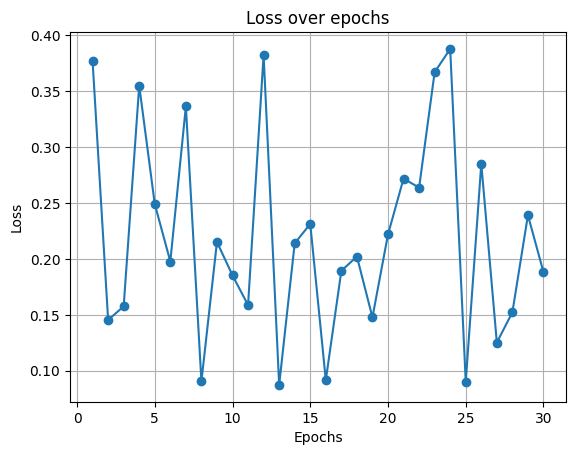

In [15]:
# Создание DataLoader
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1) 
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Инициализация модели, функции потерь и оптимизатора
model = SimpleNN()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Divice is {device}")
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# Обучение модели
num_epochs = 30
losses = [] 

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs)  
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = (y_pred > 0.5).float()


# Вывод значений потерь
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

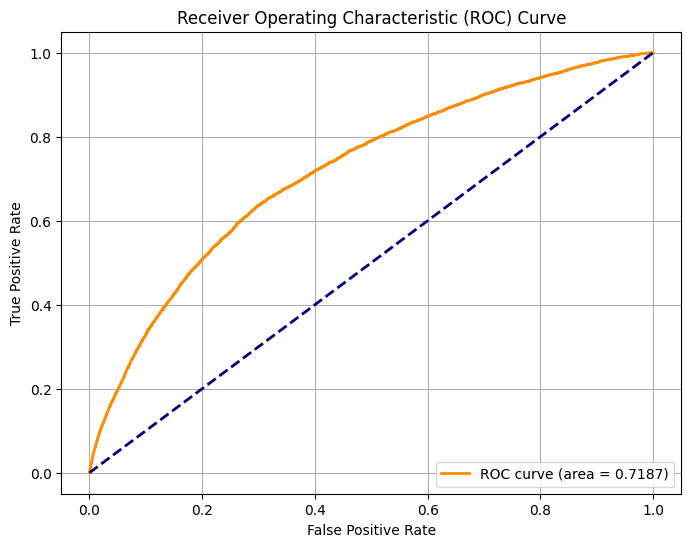

In [16]:
from sklearn.metrics import roc_curve, auc

# Оценка модели
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = y_pred.squeeze().cpu().numpy()
    y_test = y_test_tensor.squeeze().cpu().numpy()

# Получение fpr, tpr, thresholds для ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Вычисление AUC
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Нейросеть не будем обучать в несколько итераций для проведения т-теста, так как это требует значительных вычислительных ресурсов и времени